In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import pickle
import random
import importlib
import sys

import shap
from pdpbox import pdp
import matplotlib.pyplot as plt
import japanize_matplotlib

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import common

# モジュールの再読み込み
importlib.reload(common)

_common = common.Common()
_common.BASE_PATH

PosixPath('/Users/iwasakitakahiro/github')

In [3]:
common_func_path = _common.COMMON_FUNC_PATH
sys.path.append(str(common_func_path))

import func

importlib.reload(func)

<module 'func' from '/Users/iwasakitakahiro/github/共通関数/func.py'>

In [4]:
train_df = pd.read_csv('../output/中間データ/学習用データ/train_preprocessed.csv')
train_df.head()

,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,weighted_wind_speed,weighted_temp,weighted_pressure,weighted_humidity,weighted_clouds_all,valencia_weather_main_LabelEn,madrid_weather_main_LabelEn,bilbao_weather_main_LabelEn,barcelona_weather_main_LabelEn,seville_weather_main_LabelEn
0,2015-01-04 23:00:00+00:00,391.0,0.0,3981.0,2559.0,323.0,1045.0,1502.0,1991.0,7086.0,...,1.364883,276.967912,1015.043896,80.887517,0.547325,1,1,3,1,1
1,2015-01-05 00:00:00+00:00,351.0,0.0,3997.0,2755.0,310.0,1257.0,1494.0,1867.0,7087.0,...,0.973937,276.820726,999.486283,70.303155,0.312757,1,1,2,1,1
2,2015-01-05 01:00:00+00:00,350.0,0.0,3787.0,2678.0,306.0,1629.0,1484.0,1414.0,7086.0,...,1.426612,276.582165,999.434842,70.622085,2.602195,1,1,2,1,2
3,2015-01-05 02:00:00+00:00,366.0,0.0,3724.0,2426.0,311.0,1962.0,1472.0,1355.0,7086.0,...,1.035665,275.754675,998.938957,73.982853,2.419753,1,1,1,1,2
4,2015-01-05 03:00:00+00:00,377.0,0.0,3578.0,2046.0,310.0,2185.0,1438.0,1431.0,7087.0,...,1.035665,275.712079,998.548011,74.373800,2.784636,1,1,2,1,2


In [5]:
X_train = train_df.drop(columns=[_common.TARGET_COL, _common.UNIQUE_KEY_COLS])
y_train = train_df[_common.TARGET_COL]

In [6]:
# 再現性確保のための固定シード
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Optunaのシードも固定
sampler = optuna.samplers.TPESampler(seed=SEED)

# LightGBMにも同様に
default_params = {
    'objective': 'regression_l2',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'random_state': SEED,
    'verbosity': -1
}

In [7]:
tscv = TimeSeriesSplit(n_splits=5)

#### ハイパーパラメータチューニング

In [8]:
# 最適化の対象関数
def objective(trial):
    return func.run_optuna(
        trial=trial,
        features=X_train,         # 特徴量データフレーム
        target=y_train,           # 目的変数
        cv_strategy=tscv,         # ← partition_col → cv_strategy に変更済み
        model_name='lgb',
        default_columns=default_params,
        metric='rmse',
        random_seed=SEED
    )

# Optuna スタディの作成・実行
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=50, timeout=1800)

# 最良トライアルの結果
trial = study.best_trial
lgb_params = default_params | trial.params  # Python 3.9以降

# 結果の表示
print('Best trial:')
print(f'RMSE: {trial.value:.4f}')
print('Params:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2025-06-07 22:50:34,200] A new study created in memory with name: no-name-282e6676-065d-4b4e-8234-281b21b80b55


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[91]	valid_0's rmse: 8.70504
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[440]	valid_0's rmse: 20.0331
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.1358
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 14.1814
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:50:57,487] Trial 0 finished with value: 12.124144975536716 and parameters: {'learning_rate': 0.015542448978618607, 'num_leaves': 74, 'feature_fraction': 0.8875455478014229, 'bagging_fraction': 0.9570717167427538, 'bagging_freq': 8}. Best is trial 0 with value: 12.124144975536716.


Early stopping, best iteration is:
[578]	valid_0's rmse: 6.56542
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[83]	valid_0's rmse: 8.87543
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[349]	valid_0's rmse: 20.2597
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 11.1198
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 14.267
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:51:13,629] Trial 1 finished with value: 12.226579812060969 and parameters: {'learning_rate': 0.01873236473539007, 'num_leaves': 50, 'feature_fraction': 0.9603744355070039, 'bagging_fraction': 0.991627870736741, 'bagging_freq': 9}. Best is trial 0 with value: 12.124144975536716.


Early stopping, best iteration is:
[489]	valid_0's rmse: 6.61105
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 8.82499
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[272]	valid_0's rmse: 20.0853
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 11.093
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 14.3259
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:51:28,204] Trial 2 finished with value: 12.188660247831194 and parameters: {'learning_rate': 0.02279382816537334, 'num_leaves': 66, 'feature_fraction': 0.9366925870344273, 'bagging_fraction': 0.94254040539658, 'bagging_freq': 4}. Best is trial 0 with value: 12.124144975536716.


Early stopping, best iteration is:
[332]	valid_0's rmse: 6.61407
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[37]	valid_0's rmse: 8.74333
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[199]	valid_0's rmse: 19.9741
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 11.0992
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 14.0784
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:51:40,616] Trial 3 finished with value: 12.072961299081777 and parameters: {'learning_rate': 0.036407946646282316, 'num_leaves': 66, 'feature_fraction': 0.8027536899181364, 'bagging_fraction': 0.9545653243224748, 'bagging_freq': 9}. Best is trial 3 with value: 12.072961299081777.


Early stopping, best iteration is:
[319]	valid_0's rmse: 6.46976
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[63]	valid_0's rmse: 8.76759
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[280]	valid_0's rmse: 19.951
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.1455
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 14.1158
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:51:53,824] Trial 4 finished with value: 12.091469418678242 and parameters: {'learning_rate': 0.02316786340105235, 'num_leaves': 74, 'feature_fraction': 0.8150762483285954, 'bagging_fraction': 0.8737648012003949, 'bagging_freq': 10}. Best is trial 3 with value: 12.072961299081777.


Early stopping, best iteration is:
[380]	valid_0's rmse: 6.47743
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 8.79552
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[191]	valid_0's rmse: 20.2364
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 11.1216
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 14.3053
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:51:58,926] Trial 5 finished with value: 12.190331868652716 and parameters: {'learning_rate': 0.04481033010266881, 'num_leaves': 58, 'feature_fraction': 0.9577460285881492, 'bagging_fraction': 0.8633672244337742, 'bagging_freq': 6}. Best is trial 3 with value: 12.072961299081777.


Early stopping, best iteration is:
[216]	valid_0's rmse: 6.49277
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[19]	valid_0's rmse: 8.77559
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[87]	valid_0's rmse: 20.2959
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 11.1158
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 14.315
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:03,020] Trial 6 finished with value: 12.245748526904233 and parameters: {'learning_rate': 0.07398222518217204, 'num_leaves': 61, 'feature_fraction': 0.9604295284160318, 'bagging_fraction': 0.828753364902913, 'bagging_freq': 8}. Best is trial 3 with value: 12.072961299081777.


Early stopping, best iteration is:
[188]	valid_0's rmse: 6.72642
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:03,241] Trial 7 pruned. Trial was pruned at iteration 37.
[I 2025-06-07 22:52:03,259] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:03,439] Trial 9 pruned. Trial was pruned at iteration 36.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 8.82777
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 19.8666
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.2429
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 14.1102
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:07,992] Trial 10 finished with value: 12.129524661756449 and parameters: {'learning_rate': 0.08314237192881471, 'num_leaves': 94, 'feature_fraction': 0.8588335096693908, 'bagging_fraction': 0.995902646281688, 'bagging_freq': 1}. Best is trial 3 with value: 12.072961299081777.
[I 2025-06-07 22:52:08,022] Trial 11 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[81]	valid_0's rmse: 6.60016
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[34]	valid_0's rmse: 8.74927
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[270]	valid_0's rmse: 19.9902
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.2906
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 14.1164
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:16,197] Trial 12 finished with value: 12.113710061015448 and parameters: {'learning_rate': 0.03455716795434382, 'num_leaves': 84, 'feature_fraction': 0.8410064845495937, 'bagging_fraction': 0.805494736185089, 'bagging_freq': 8}. Best is trial 3 with value: 12.072961299081777.


Early stopping, best iteration is:
[289]	valid_0's rmse: 6.42213
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 8.70635
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[152]	valid_0's rmse: 19.9677
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.1643
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 14.039
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:22,043] Trial 13 finished with value: 12.08502236042605 and parameters: {'learning_rate': 0.05307763345162376, 'num_leaves': 72, 'feature_fraction': 0.8360456661366756, 'bagging_fraction': 0.9020691583296819, 'bagging_freq': 4}. Best is trial 3 with value: 12.072961299081777.


Early stopping, best iteration is:
[243]	valid_0's rmse: 6.54775
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[28]	valid_0's rmse: 8.75868
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[165]	valid_0's rmse: 20.276
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.1364
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 14.1599
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:28,800] Trial 14 finished with value: 12.202753985472155 and parameters: {'learning_rate': 0.052300018216419816, 'num_leaves': 98, 'feature_fraction': 0.8464010825951757, 'bagging_fraction': 0.9693769516288284, 'bagging_freq': 3}. Best is trial 3 with value: 12.072961299081777.


Early stopping, best iteration is:
[180]	valid_0's rmse: 6.68276
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:29,042] Trial 15 pruned. Trial was pruned at iteration 26.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's rmse: 8.79037
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[94]	valid_0's rmse: 20.1567
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.1572
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 13.888
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:33,468] Trial 16 finished with value: 12.123696604538479 and parameters: {'learning_rate': 0.09258472051970208, 'num_leaves': 83, 'feature_fraction': 0.8313644999212616, 'bagging_fraction': 0.9265316340612019, 'bagging_freq': 2}. Best is trial 3 with value: 12.072961299081777.
[I 2025-06-07 22:52:33,498] Trial 17 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[118]	valid_0's rmse: 6.62628
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[26]	valid_0's rmse: 8.78636
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[177]	valid_0's rmse: 20.2227
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.1314
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 13.9675
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:39,343] Trial 18 finished with value: 12.17292258570629 and parameters: {'learning_rate': 0.06159890516986741, 'num_leaves': 91, 'feature_fraction': 0.8263625402750364, 'bagging_fraction': 0.9063078215900505, 'bagging_freq': 7}. Best is trial 3 with value: 12.072961299081777.
[I 2025-06-07 22:52:39,371] Trial 19 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[135]	valid_0's rmse: 6.75669
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:39,551] Trial 20 pruned. Trial was pruned at iteration 18.
[I 2025-06-07 22:52:39,581] Trial 21 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,611] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,648] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,681] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,717] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,748] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,776] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,811] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,840] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,872] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,905] Trial 31 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:39,946] Trial 32 pruned. Trial was pruned a

Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:40,374] Trial 38 pruned. Trial was pruned at iteration 28.
[I 2025-06-07 22:52:40,406] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2025-06-07 22:52:40,431] Trial 40 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:40,701] Trial 41 pruned. Trial was pruned at iteration 27.


Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:40,989] Trial 42 pruned. Trial was pruned at iteration 27.
[I 2025-06-07 22:52:41,216] Trial 43 pruned. Trial was pruned at iteration 19.


Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:41,250] Trial 44 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 8.82281
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 19.9867
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.1636
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 13.8882
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:45,131] Trial 45 finished with value: 12.1116835903769 and parameters: {'learning_rate': 0.08898548739013204, 'num_leaves': 83, 'feature_fraction': 0.8107581304587466, 'bagging_fraction': 0.9096635929543018, 'bagging_freq': 6}. Best is trial 3 with value: 12.072961299081777.


Early stopping, best iteration is:
[92]	valid_0's rmse: 6.69714
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 8.76853
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 20.0156
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.2503
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	valid_0's rmse: 13.8702
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:48,721] Trial 46 finished with value: 12.126867001407309 and parameters: {'learning_rate': 0.09854194507013946, 'num_leaves': 66, 'feature_fraction': 0.8071146567225794, 'bagging_fraction': 0.8848726883049074, 'bagging_freq': 6}. Best is trial 3 with value: 12.072961299081777.


Early stopping, best iteration is:
[106]	valid_0's rmse: 6.72974
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 8.80195
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[96]	valid_0's rmse: 19.9396
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	valid_0's rmse: 11.1408
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[3]	valid_0's rmse: 13.9385
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:53,191] Trial 47 finished with value: 12.064556452354088 and parameters: {'learning_rate': 0.07051987714040171, 'num_leaves': 78, 'feature_fraction': 0.8107862167374551, 'bagging_fraction': 0.906224046254738, 'bagging_freq': 10}. Best is trial 47 with value: 12.064556452354088.
[I 2025-06-07 22:52:53,287] Trial 48 pruned. Trial was pruned at iteration 16.


Early stopping, best iteration is:
[141]	valid_0's rmse: 6.50189
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-06-07 22:52:53,451] Trial 49 pruned. Trial was pruned at iteration 17.


Best trial:
RMSE: 12.0646
Params:
learning_rate: 0.07051987714040171
num_leaves: 78
feature_fraction: 0.8107862167374551
bagging_fraction: 0.906224046254738
bagging_freq: 10


#### 全データで学習

In [9]:
# LightGBM Dataset の作成
lgb_train = lgb.Dataset(X_train, label=y_train)

callbacks = [
    lgb.log_evaluation(period=50)
]

# モデルの再学習（最終学習）
final_model = lgb.train(
    default_params,
    train_set=lgb_train,
    callbacks=callbacks,
)

# トレーニングデータで予測
y_train_pred = final_model.predict(X_train)

# RMSEを計算
final_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"LightGBMのトレーニングRMSE: {final_rmse:.4f}")

LightGBMのトレーニングRMSE: 3.9353


In [10]:
# 保存用のディクショナリにまとめる
model_package = {
    'model': final_model,
    'feature_name': X_train.columns.tolist()
}

# 保存
with open('../output/モデル/lgb_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

#### 特徴量重要度

In [11]:
shap_sample = X_train.sample(n=100, random_state=1234)

In [12]:
# shap値の取得
def get_shap_value(model, shap_sample, model_type, masker_data=None):
    if model_type == 'tree':
        explainer =shap.TreeExplainer(model, feature_perturbation='tree_path_dependent', model_output='raw')
    shap_values = explainer.shap_values(shap_sample)
    shap_values = np.array(shap_values, dtype=np.float64)

    return shap_values

# 重要特徴量の計算
def compute_shap_importance(shap_values, shap_sample):
    if isinstance(shap_values, list):
        shap_array = np.abs(shap_values[0])
    elif hasattr(shap_values, 'values'):
        shap_array = np.abs(shap_values.values)
    else:
        shap_array = np.abs(shap_values)
    
    shap_importance = pd.DataFrame({
        '特徴量': shap_sample.columns,
        '特徴量の重要度': shap_array.mean(axis=0)
    }).sort_values(by='特徴量の重要度', ascending=False)

    max_importance = shap_importance['特徴量の重要度'].max()
    shap_importance['特徴量の相対的重要度'] = shap_importance['特徴量の重要度'] / max_importance

    display(shap_importance.head(100))

    return shap_importance

In [13]:
shap_values = get_shap_value(final_model, shap_sample, 'tree', masker_data=None)
shap_importance = compute_shap_importance(shap_values, shap_sample)

,特徴量,特徴量の重要度,特徴量の相対的重要度
21,weekday_sin,2.849699,1.000000
24,month_cos,2.509558,0.880640
23,month_sin,2.384336,0.836698
3,generation_fossil_hard_coal,2.229423,0.782336
20,hour_cos,2.056771,0.721750
39,weighted_wind_speed,2.051181,0.719789
19,hour_sin,1.813259,0.636299
31,gene_sum_rolling_mean672,0.941178,0.330273
10,generation_other_renewable,0.919767,0.322759
34,total_load_actual_lag48,0.858578,0.301287


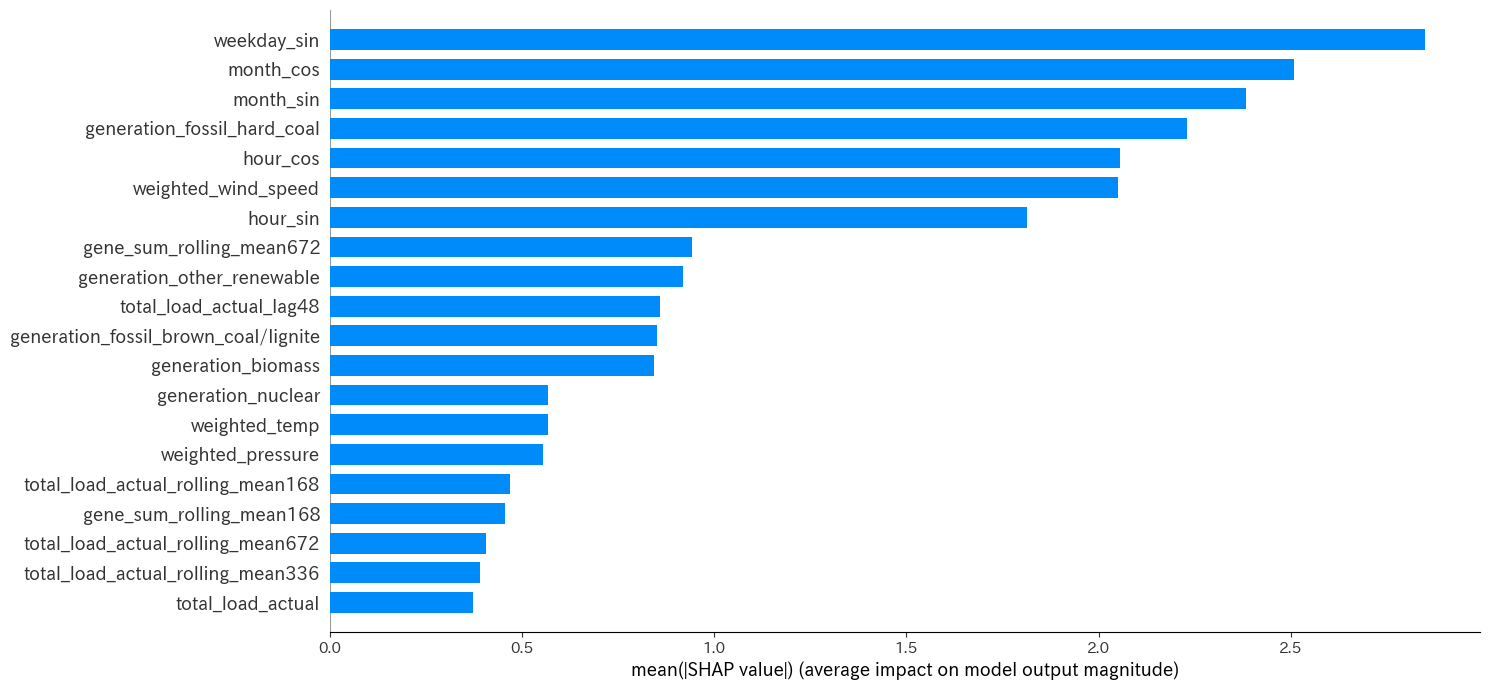

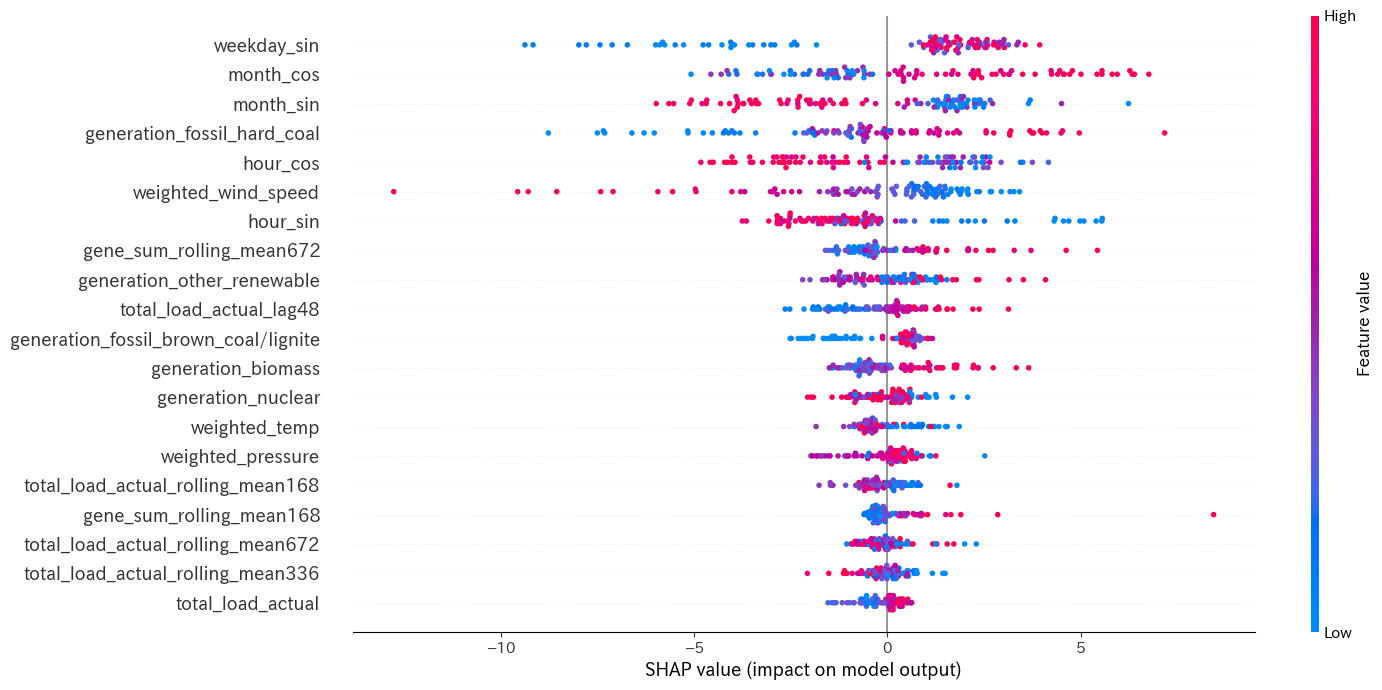

In [14]:
# 特徴量重要度の可視化
shap.summary_plot(shap_values, shap_sample, plot_type='bar', plot_size=(15, 7))
shap.summary_plot(shap_values, shap_sample, plot_size=(15, 7))

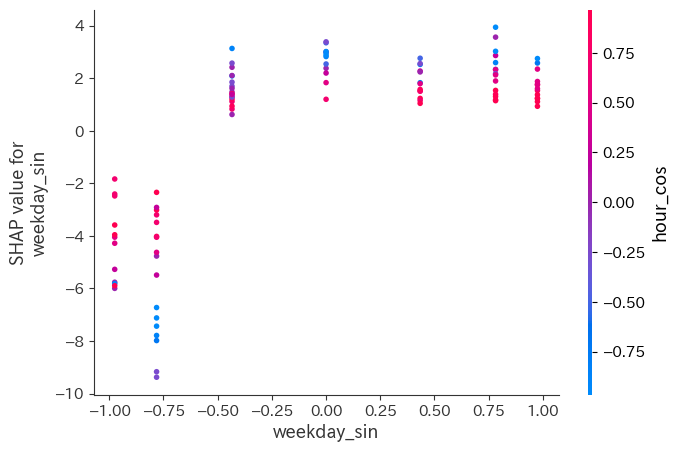

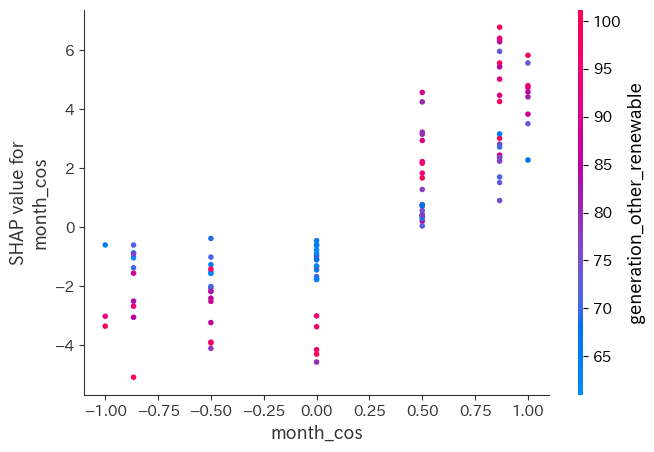

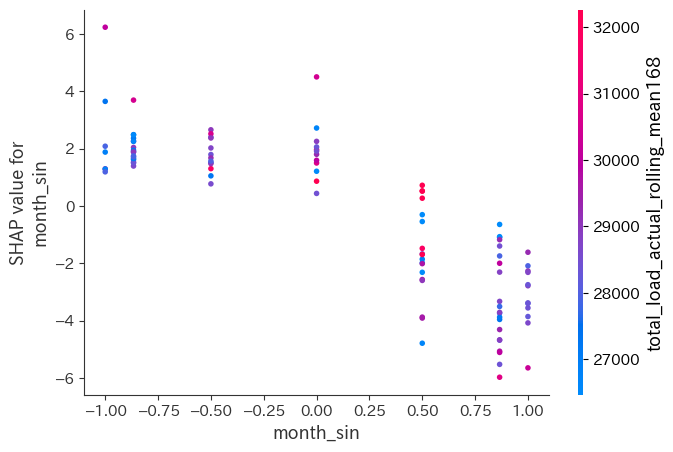

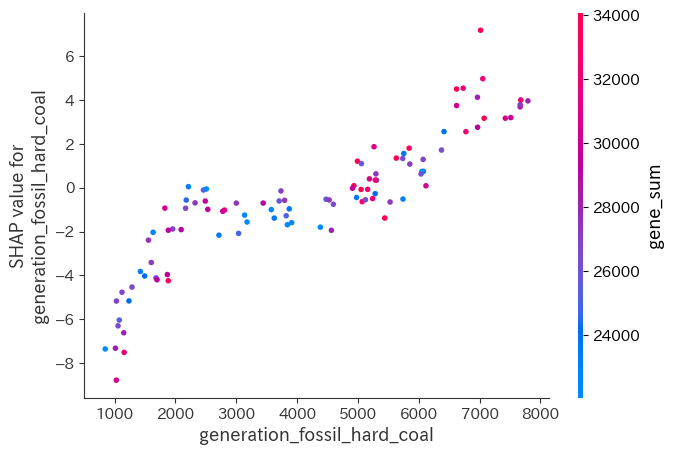

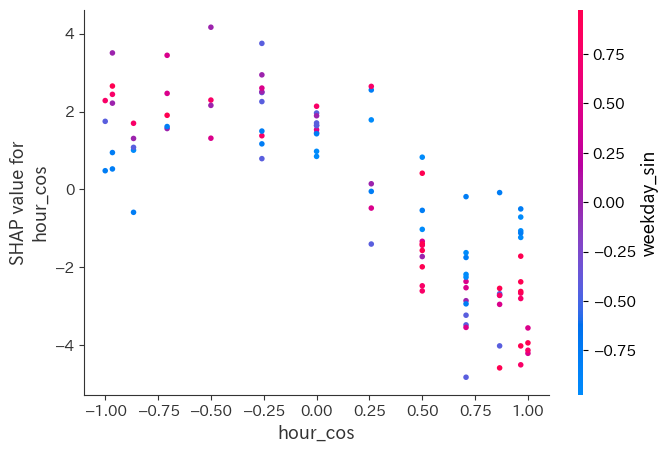

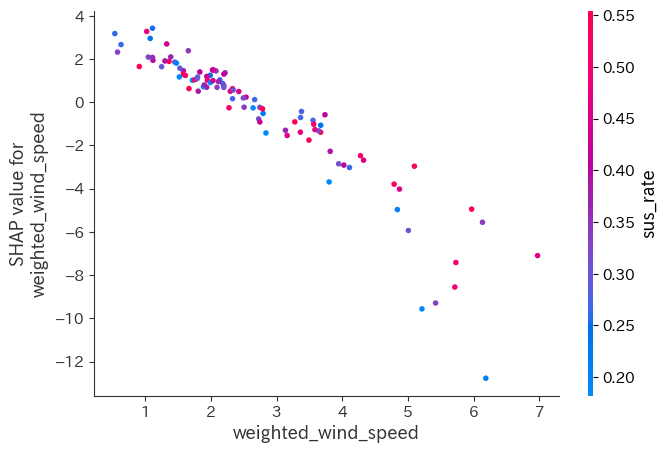

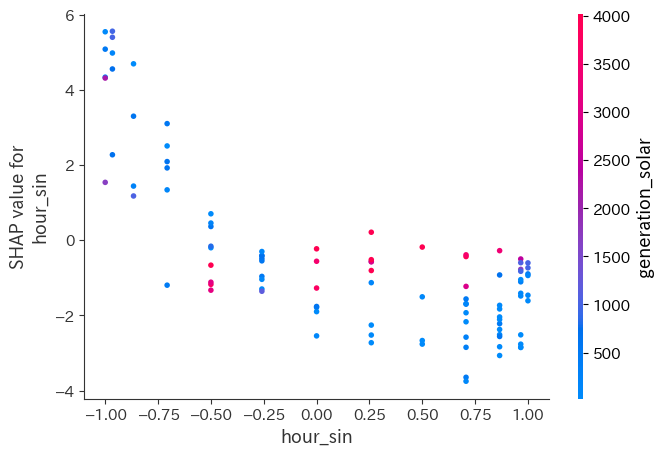

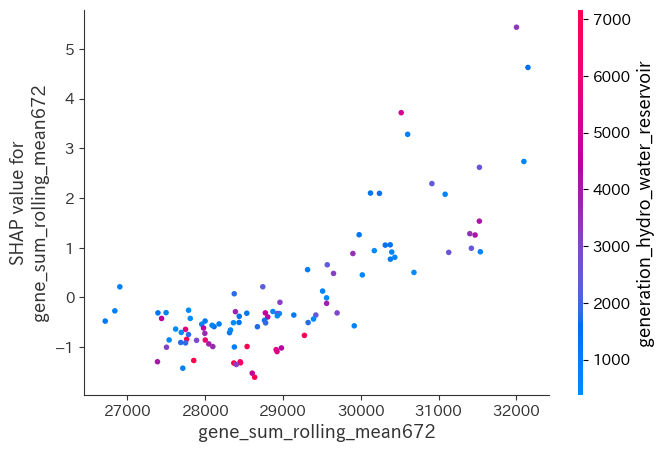

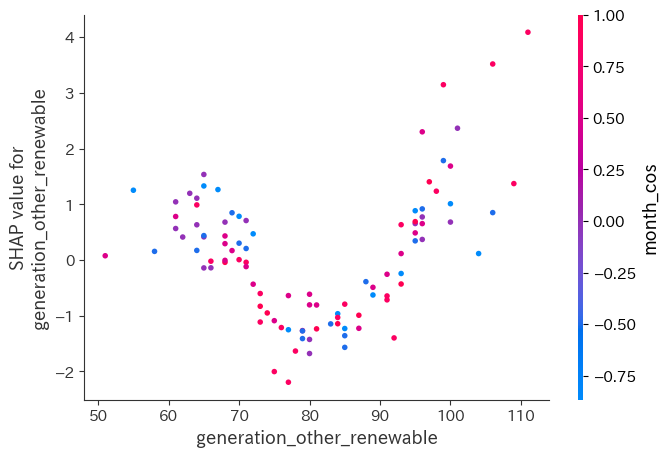

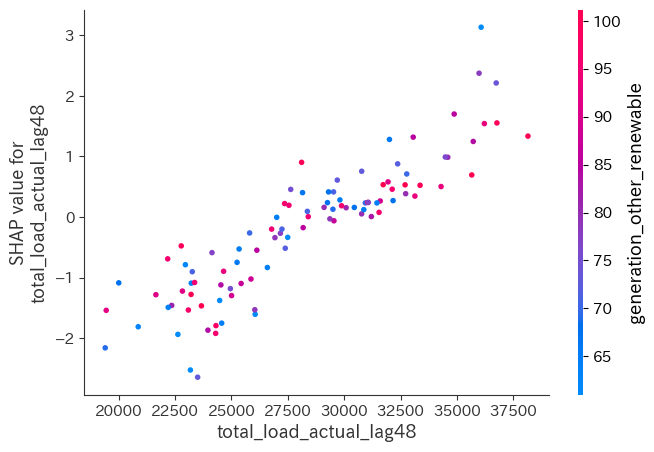

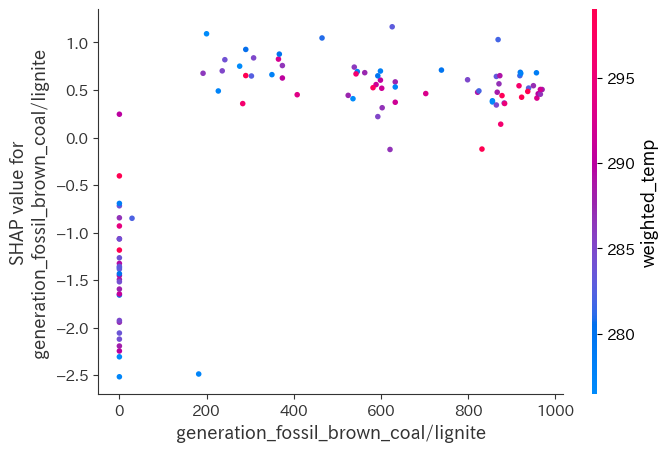

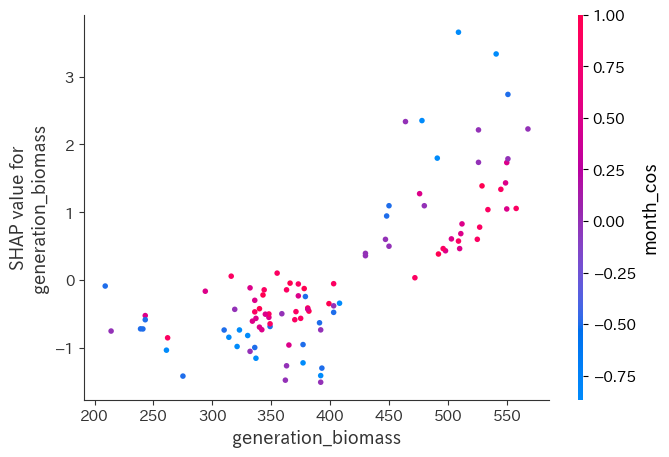

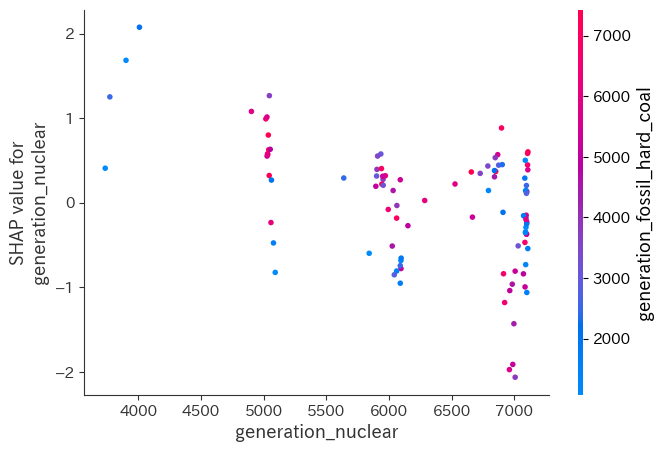

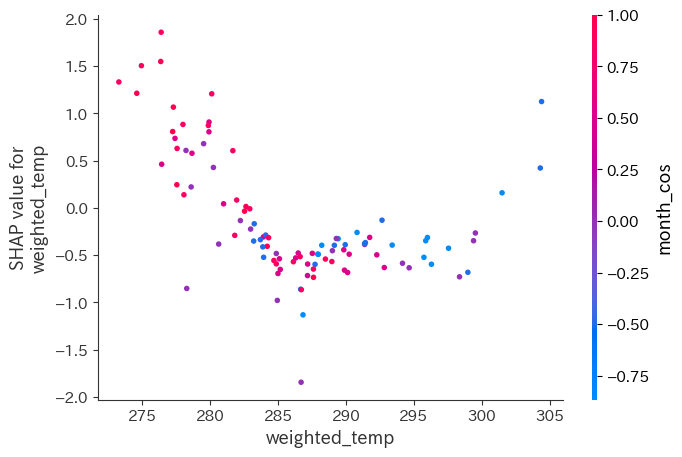

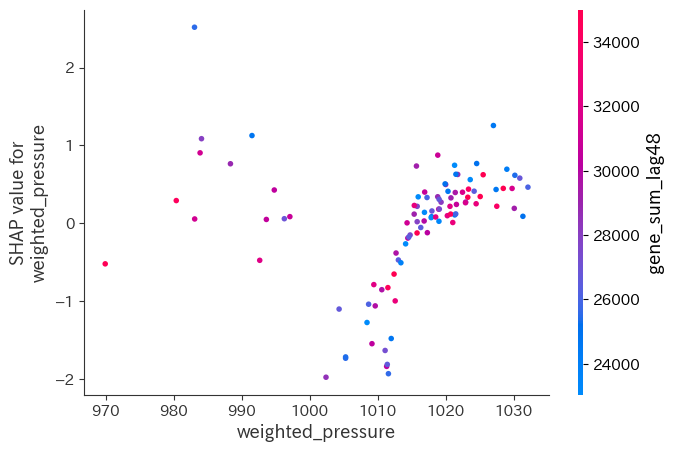

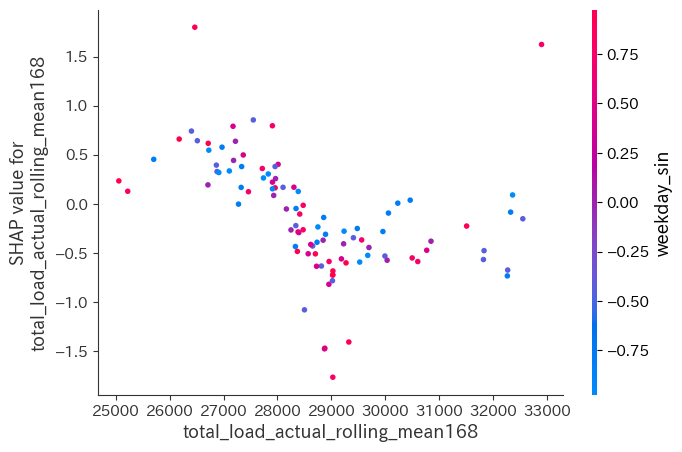

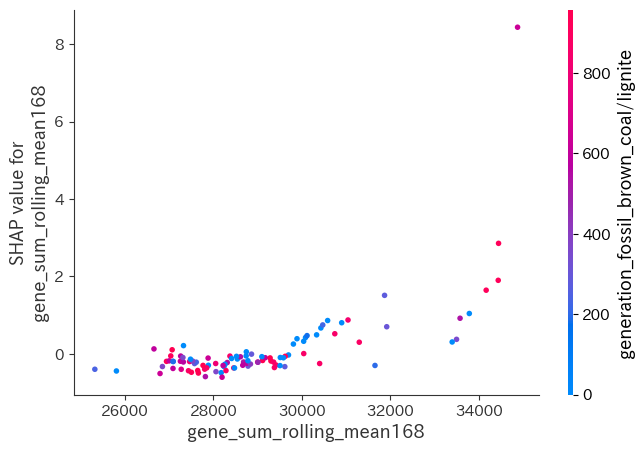

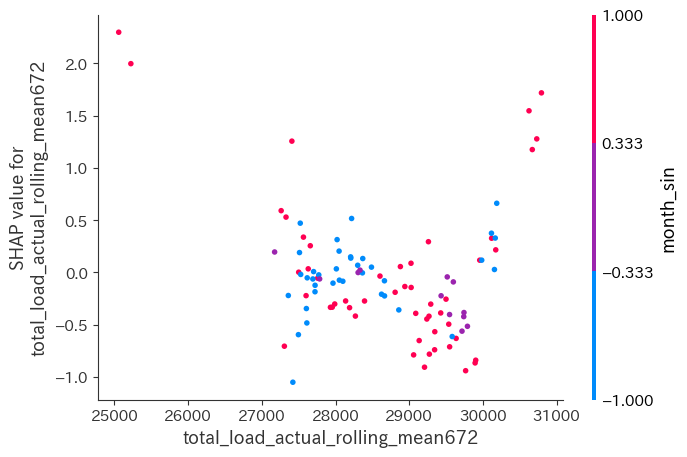

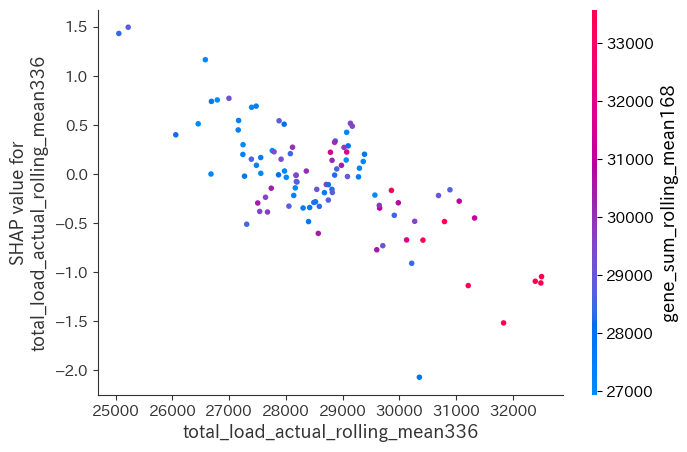

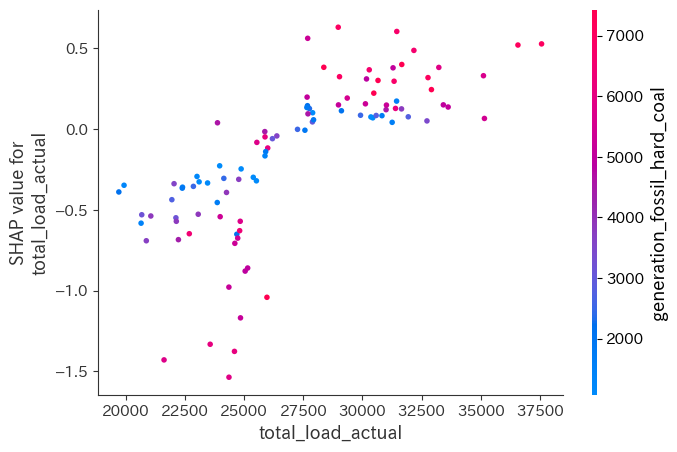

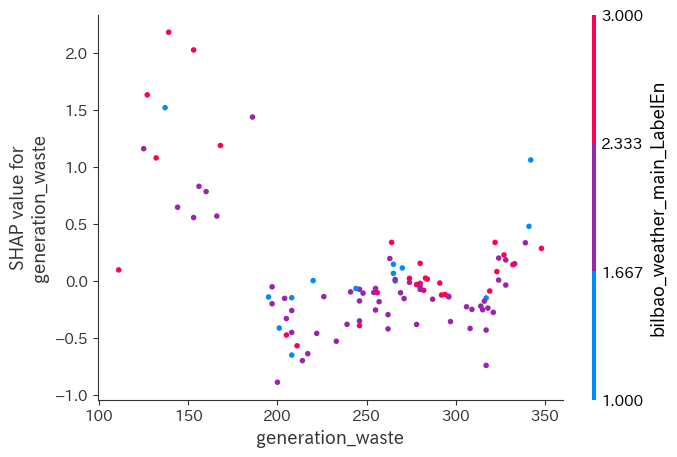

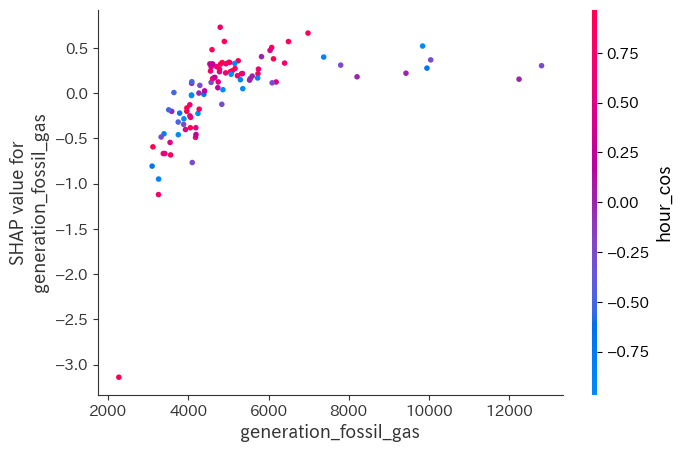

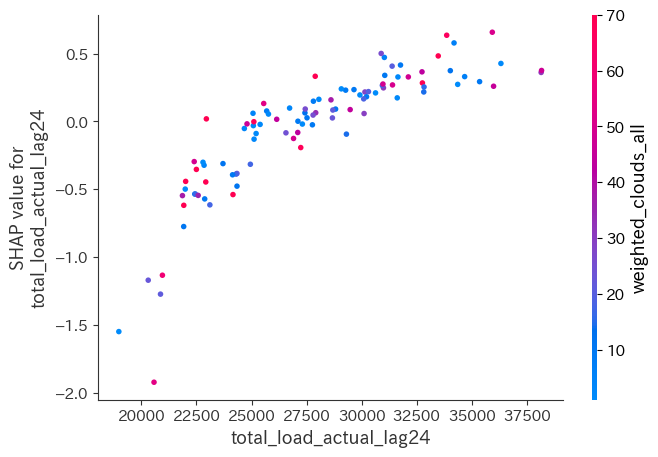

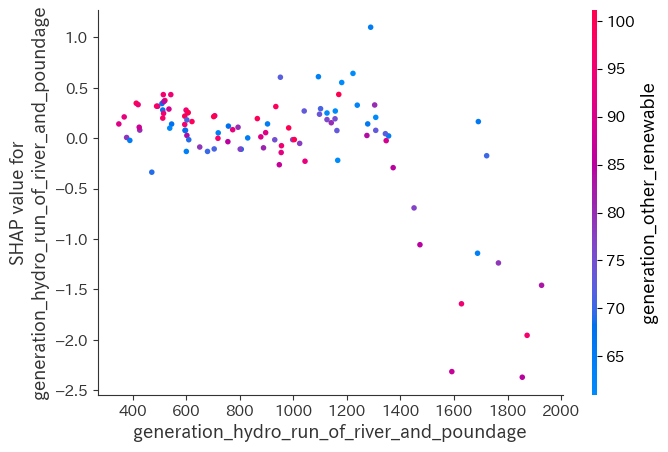

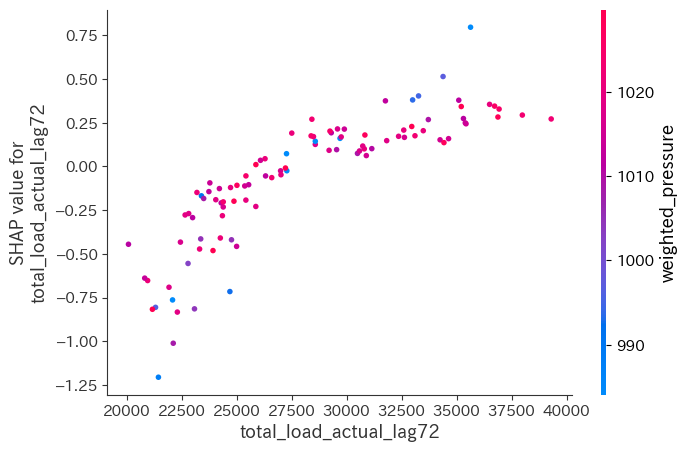

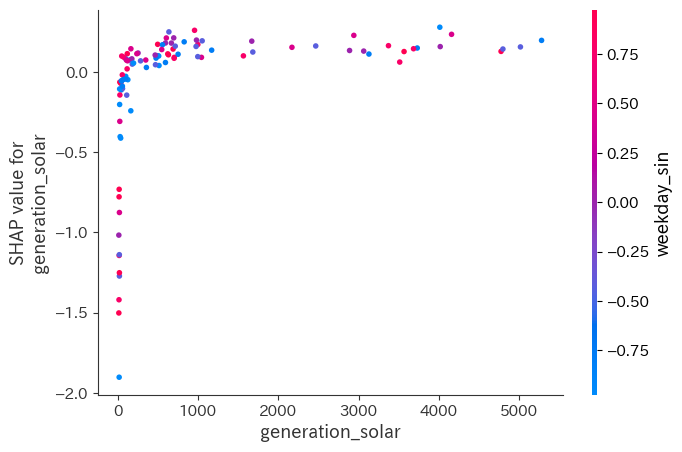

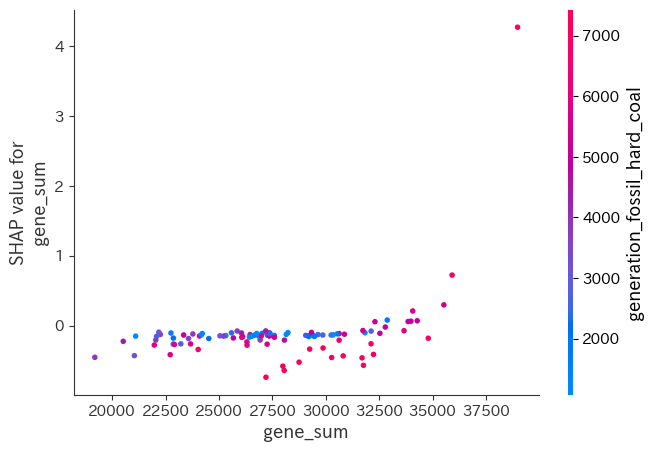

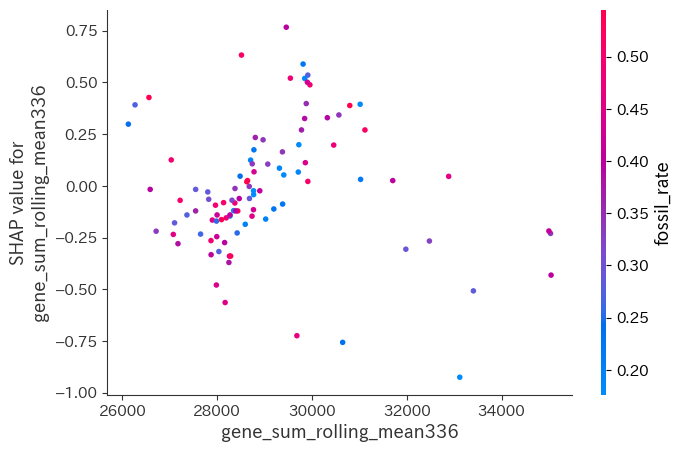

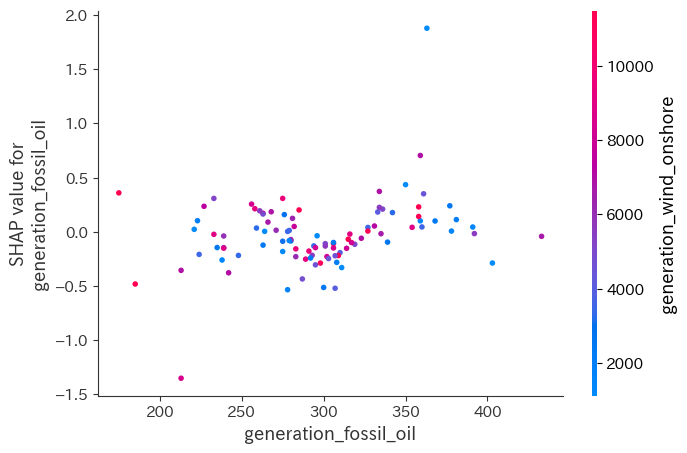

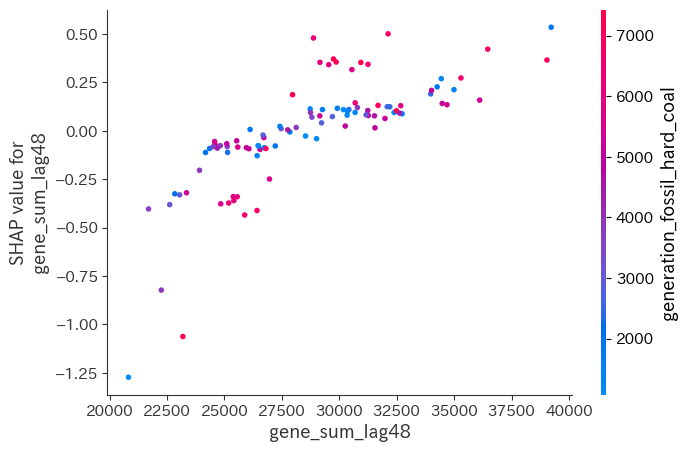

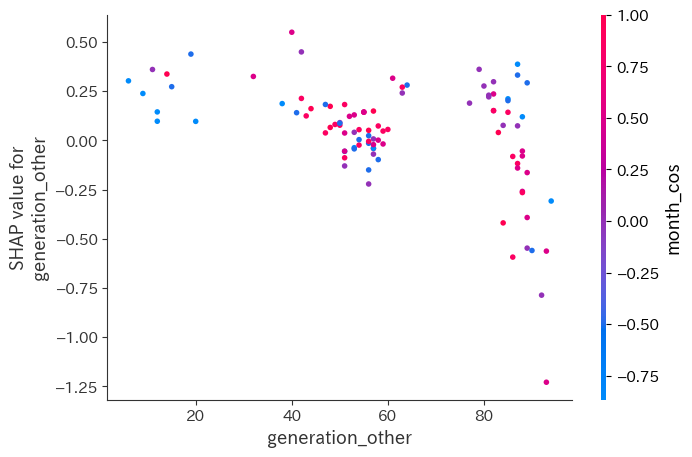

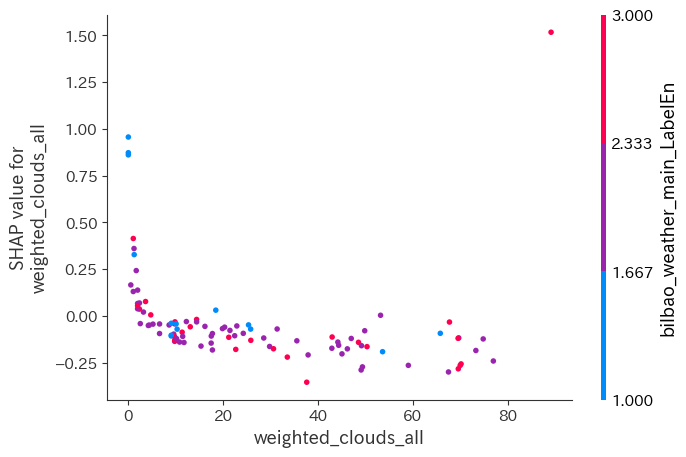

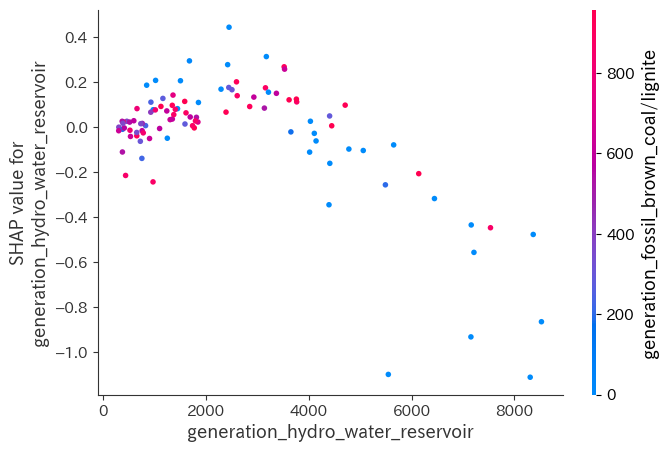

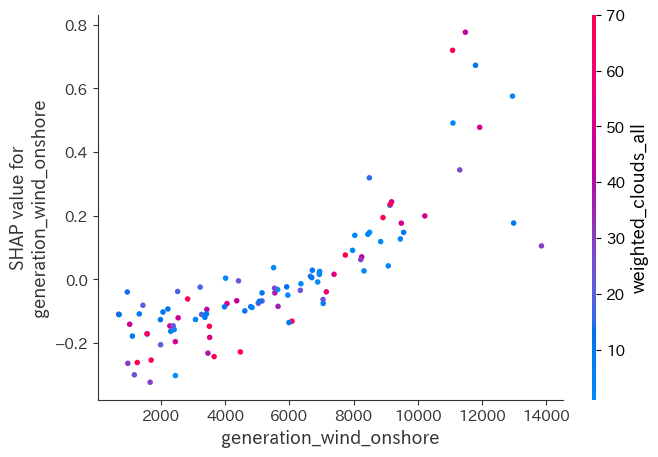

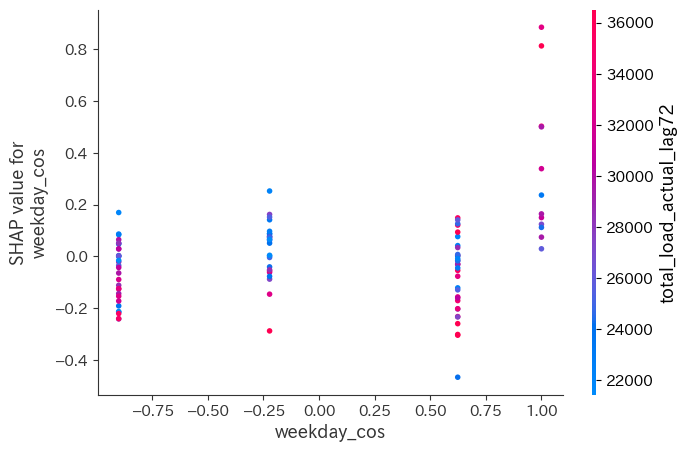

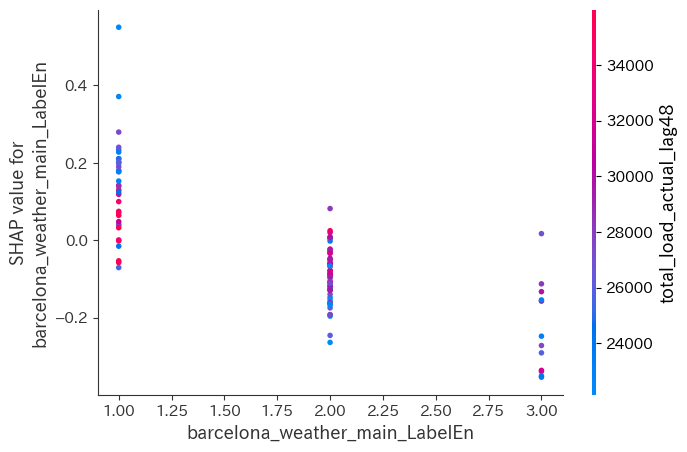

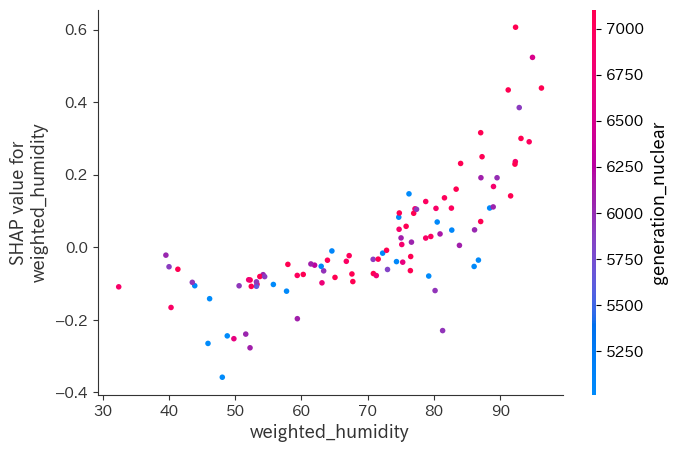

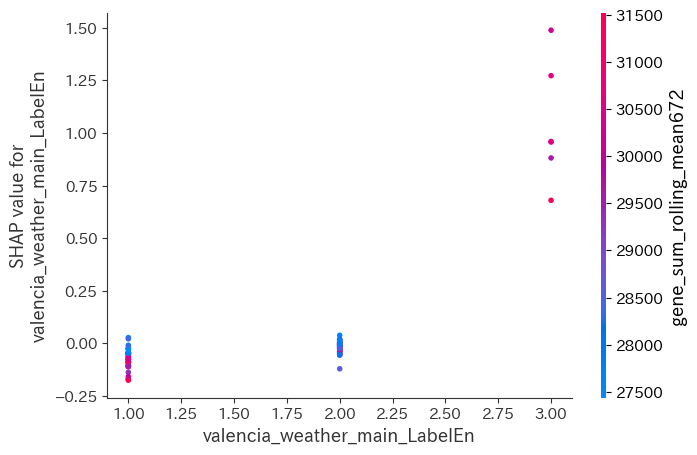

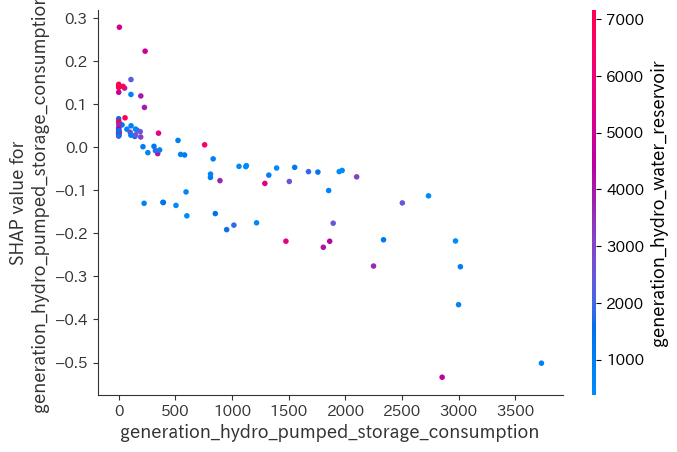

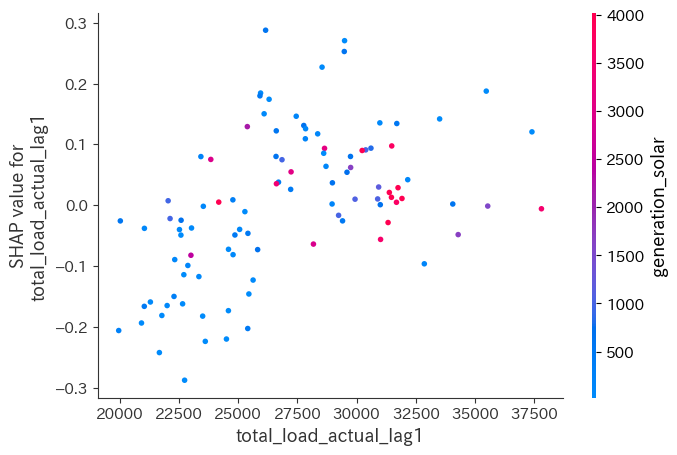

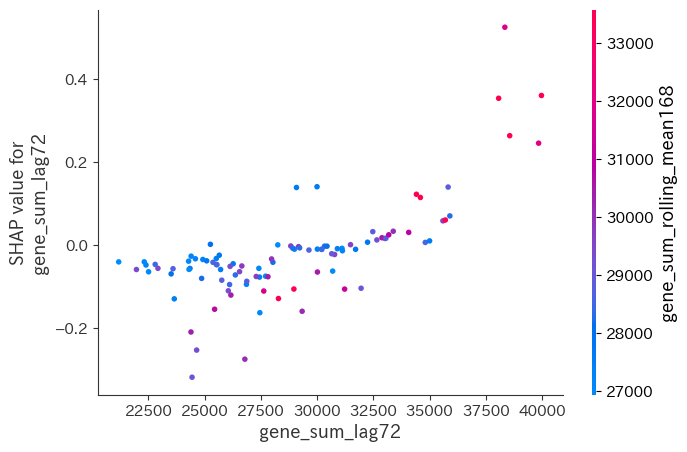

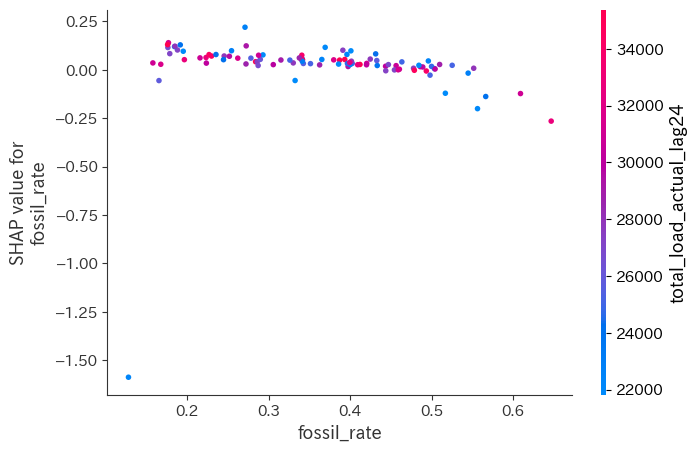

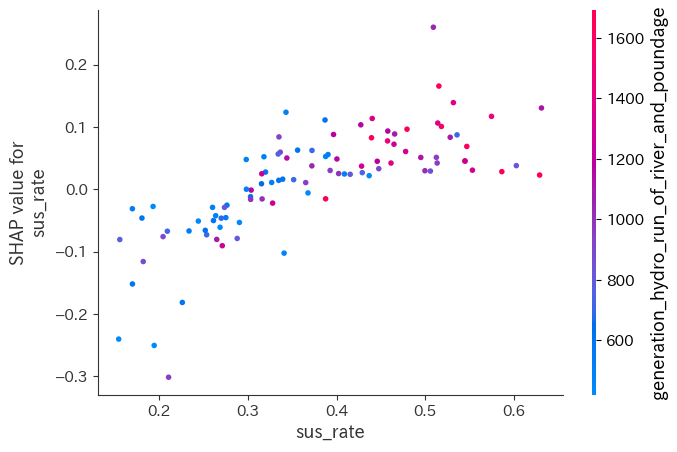

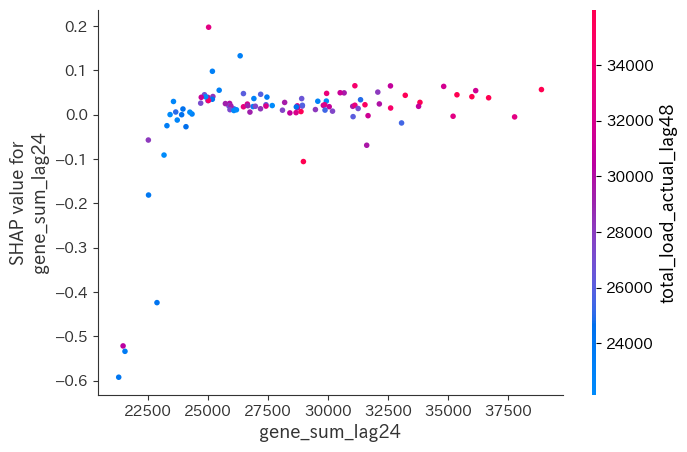

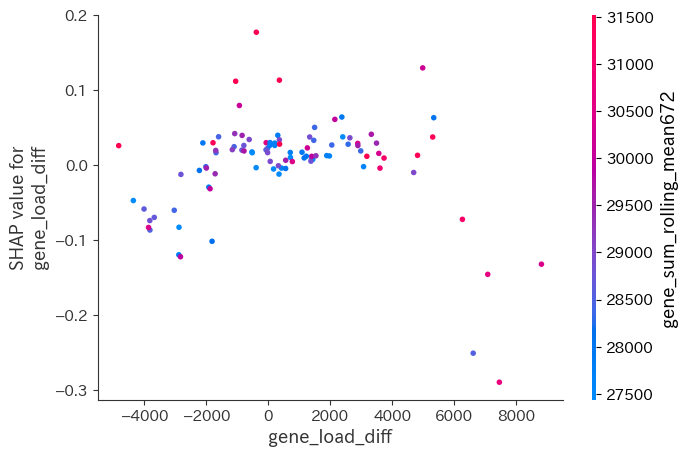

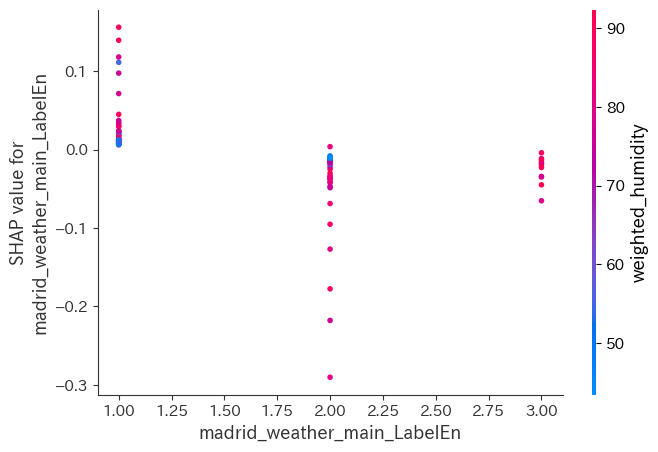

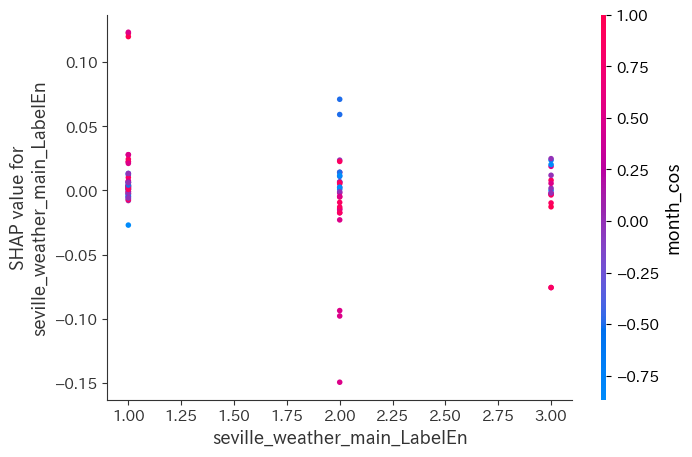

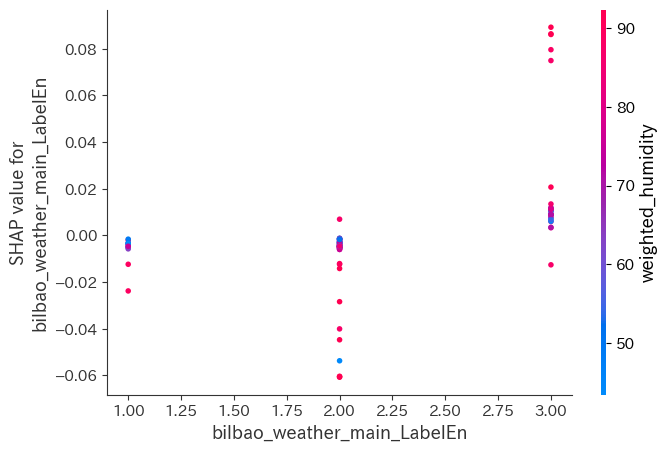

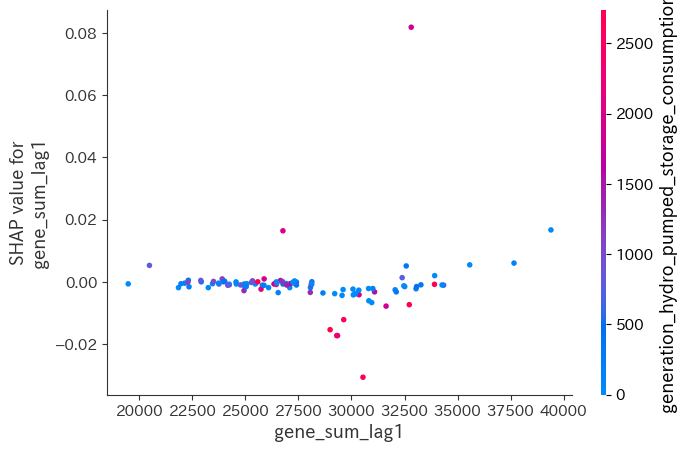

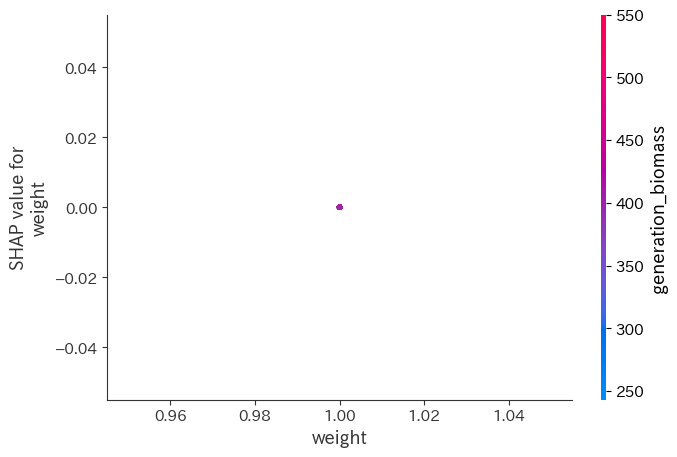

In [15]:
# 特徴量値の変化に応じた変化を描画
for feature in shap_importance['特徴量']:
    shap.dependence_plot(feature, shap_values, shap_sample)

#### 特徴量の作用

In [16]:
# スケーリングされた値を元のスケールに戻す関数
def _inverse_scale(values, feature_name, scaler_params_path):
    scaler_df = pd.read_csv(scaler_params_path, encoding='utf-8-sig')
    row = scaler_df[scaler_df['特徴量名'] == feature_name]

    if row.empty:
        print(f'スケーリング情報が見つかりません: {feature_name}')
        return values
    
    method = row.iloc[0]['手法']

    if method == 'std':
        mean = row.iloc[0]['mean']
        std = row.iloc[0]['std']
        return values * std + mean
    

# 学習時の特徴量のリストを取得する
def _get_model_features_for_pdp(model):
    if isinstance(model, lgb.Booster):
        return model.feature_name()
    else:
        return None


# PDPを描画する関数
def _drew_pdp(df, model_features, feature_name, pred_func, title_suffix='', num_grid_points=50, scaler_param_path=None):
    pdp_isolated = pdp.PDPIsolate(
        model=None if pred_func else model,
        df=df[model_features],
        model_features=model_features,
        feature=feature_name,
        feature_name=feature_name,
        n_classes=0,
        num_grid_points=num_grid_points,
        pred_func=pred_func
    )

    x_vals = pdp_isolated.feature_info.grids
    y_vals = pdp_isolated.results[0].pdp

    # スケーリングを元に戻す
    if scaler_param_path is not None:
        x_vals = _inverse_scale(x_vals, feature_name, scaler_param_path)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, marker='o', linestyle='-')
    plt.xlabel(feature_name)
    plt.ylabel('予測値')
    plt.title(f'特徴量の作用: {feature_name}_{title_suffix}')
    plt.grid(True)
    plt.show()


# 単一モデルに対してPDPを実施する関数
def plot_pdp(model, features, top10_feature_list, model_name='', num_grid_points=50, scaler_param_path=None):
    model_features = _get_model_features_for_pdp(model)

    def pred_func(_, X):
        if isinstance(model, lgb.Booster):
            return model.predict(pd.DataFrame(X, columns=model_features))
        
    for top_feature in top10_feature_list:
        _drew_pdp(
            features,
            model_features,
            top_feature,
            pred_func,
            title_suffix=model_name,
            num_grid_points=num_grid_points,
            scaler_param_path=scaler_param_path
        )

using provided pred_func.


100%|██████████| 15/15 [00:00<00:00, 917.44it/s]


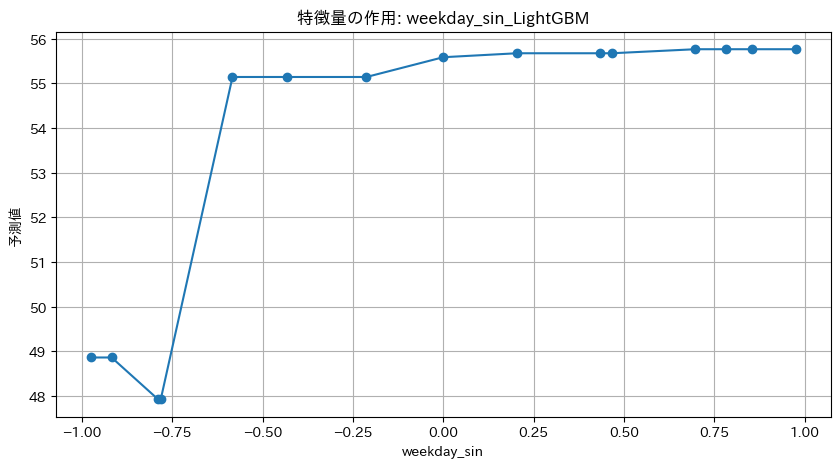

using provided pred_func.


100%|██████████| 23/23 [00:00<00:00, 368.38it/s]


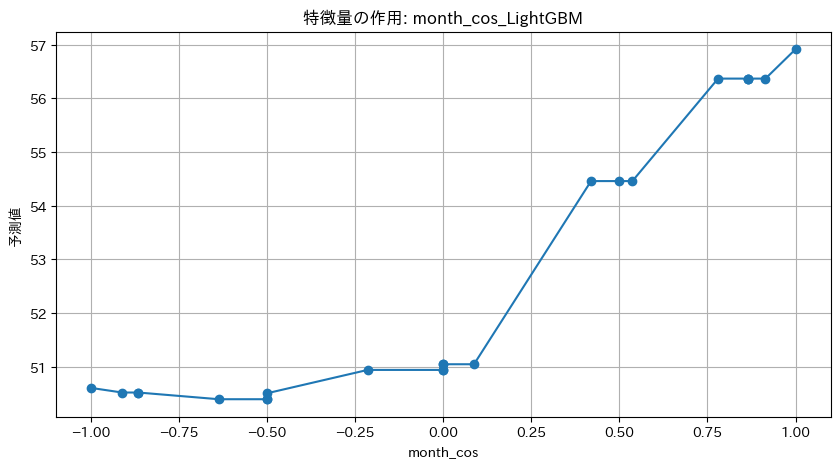

using provided pred_func.


100%|██████████| 23/23 [00:00<00:00, 1171.92it/s]


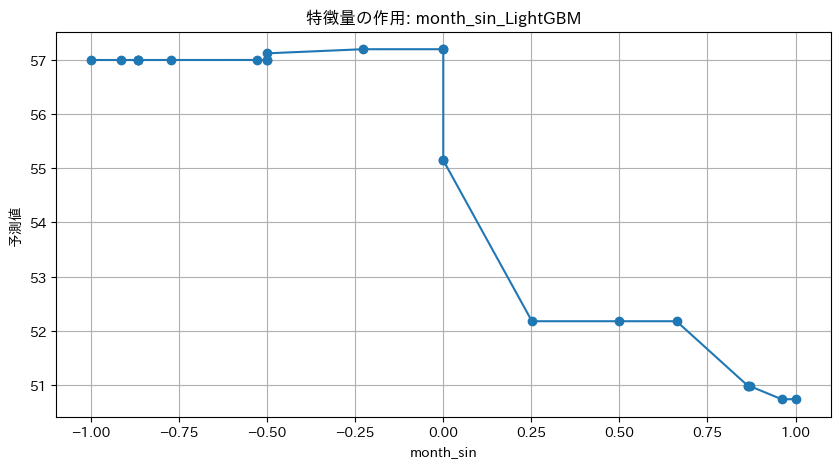

using provided pred_func.


100%|██████████| 149/149 [00:00<00:00, 1326.73it/s]


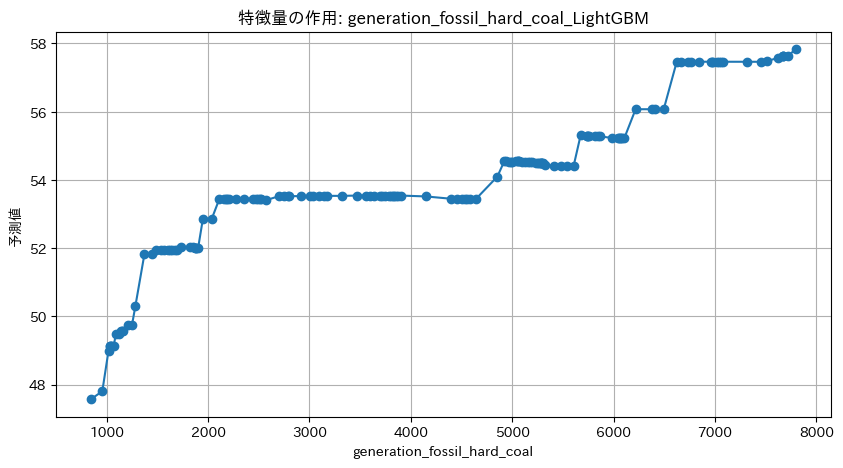

using provided pred_func.


100%|██████████| 45/45 [00:00<00:00, 1231.73it/s]


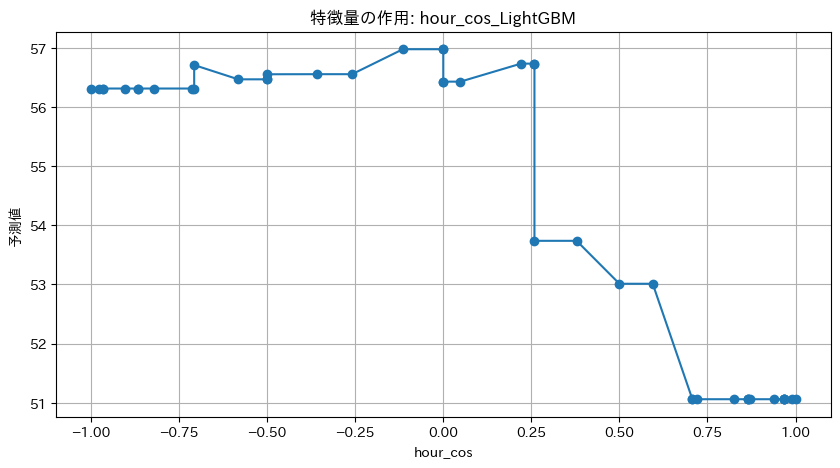

using provided pred_func.


100%|██████████| 148/148 [00:00<00:00, 1316.81it/s]


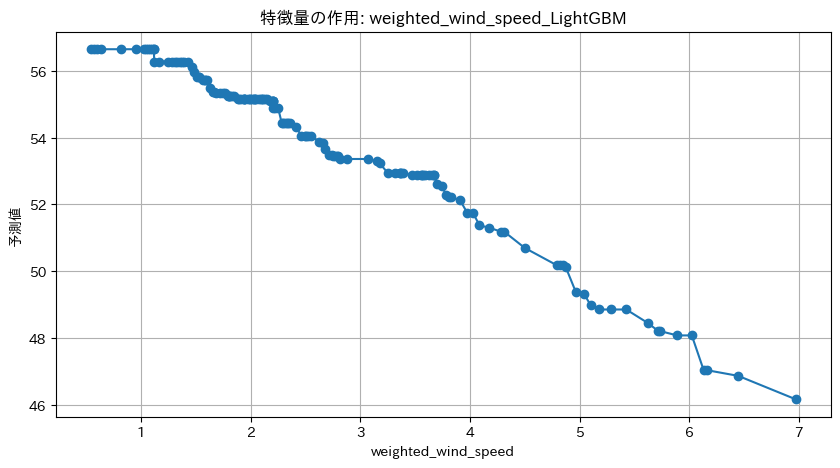

using provided pred_func.


100%|██████████| 47/47 [00:00<00:00, 1257.76it/s]


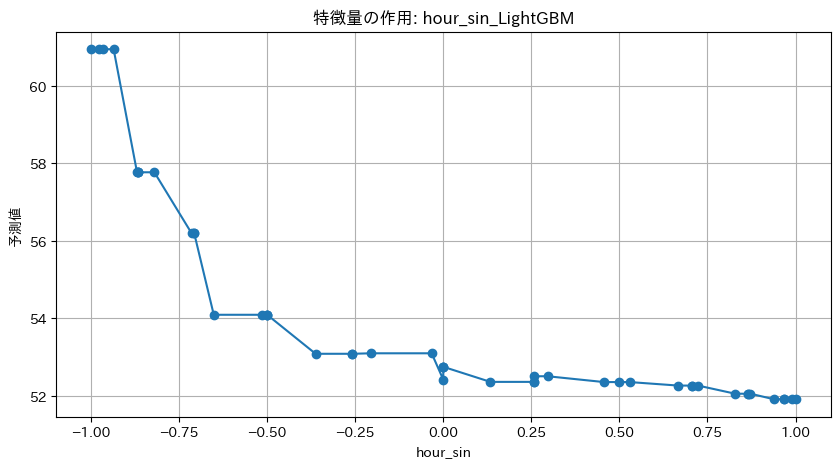

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 1209.03it/s]


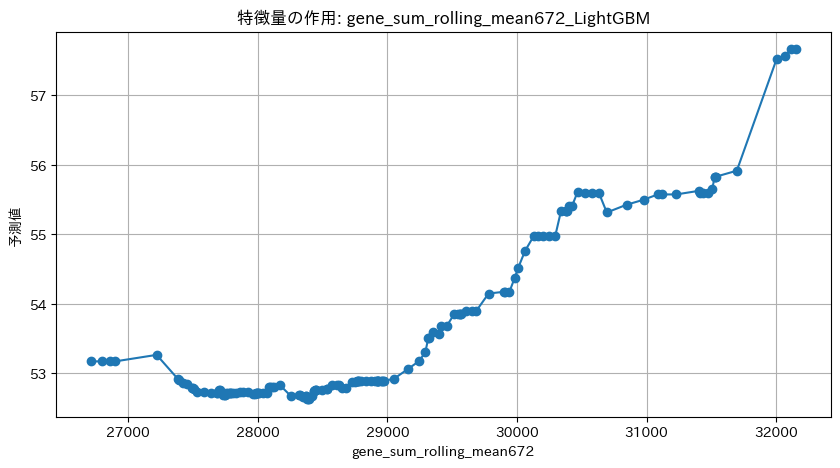

using provided pred_func.


100%|██████████| 94/94 [00:00<00:00, 1332.42it/s]


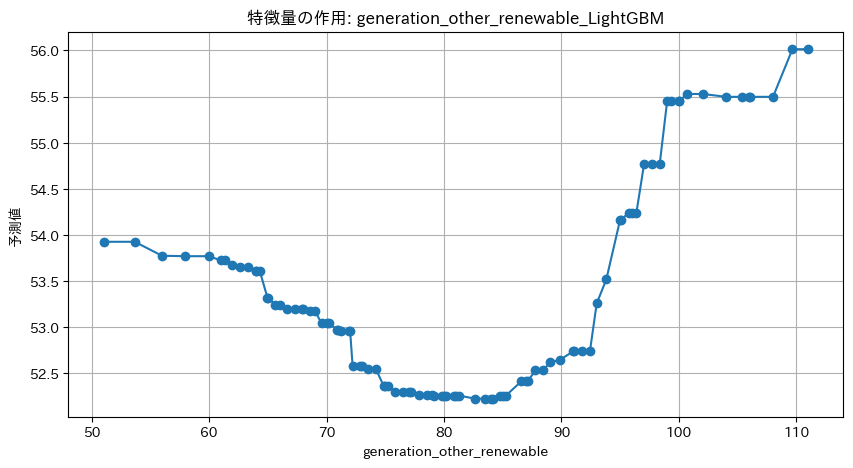

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 1220.72it/s]


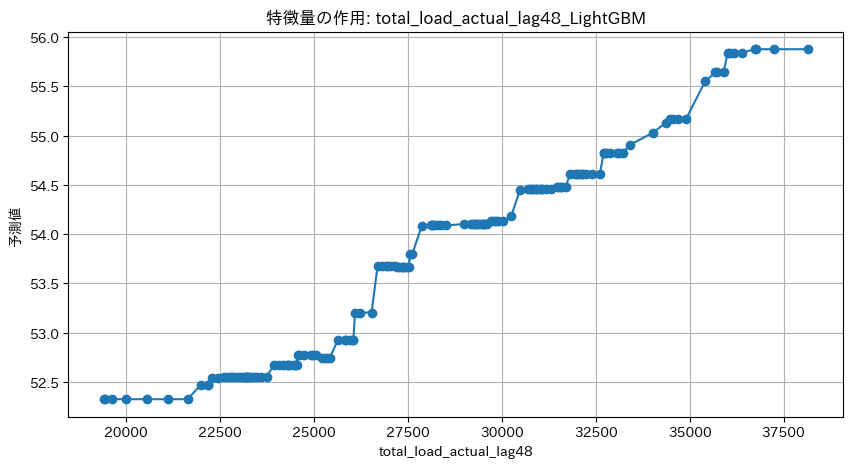

In [17]:
top10_list = shap_importance.iloc[0:10, 0].to_list()
plot_pdp(final_model, shap_sample, top10_list, 'LightGBM', num_grid_points=150, scaler_param_path=None)